# BE - Benign Equivalized

In [1]:
import numpy as np
from numpy import genfromtxt, argmax
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
import pandas as pd
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score, mean_absolute_error, matthews_corrcoef, roc_curve, auc,RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (27, 10)
# plt.rcParams["xtick.labelsize"] = 10
sns.set_context('paper', font_scale=2)

In [2]:
def calculate_classifications(y_p, y, a): #calculate correct and wrong classifications by attack category
    y_p = y_p.flatten()
    df= pd.DataFrame({'pred':y_p, 'label':y, 'attack':a})
    df['misclassification'] = df.apply(f, axis=1)
    df = df[df['attack']!='Benign']
    attacks = df['attack'].unique()
    att_dic_w = dict((n, 0) for n in attacks)
    att_dic_c = att_dic_w.copy()
    count_series = df.groupby(['attack', 'misclassification']).size()
    print(count_series)
    for key in attacks:
        counts = count_series.get(key).to_list()
        print(counts)
        if count_series.get(key).get(0) == None:
            counts.insert(0,0)
        elif count_series.get(key).get(1) == None:
            counts.insert(1,0)
        att_dic_w[key] = counts[1]
        att_dic_c[key] = counts[0]
    return att_dic_w, att_dic_c

def plot_roc_auc(y_true, y_pred):
    ns_probs = [0 for _ in range(len(y_true))]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    nfpr, ntpr, thresholds = roc_curve(y_true, ns_probs)
    ns_auc = auc(nfpr, ntpr)
    lr_auc = auc(fpr, tpr)
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    print('Logistic: ROC AUC=%.3f' % (ns_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='0.5')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_attack_classifications(att_dic_w, att_dic_c): #plot correct and wrong classifications by attack category
    width = 0.4
    keys = att_dic_w.keys()
    values_w = att_dic_w.values()
    values_c = att_dic_c.values()
    x = np.arange(len(keys))
    fig, ax = plt.subplots()
    r1 = ax.bar(x - width/2, values_w, width, label = "Misclassified")
    r2 = ax.bar(x + width/2, values_c, width, label = "Correct Classification")
    ax.set_ylabel('Count')
    ax.set_xlabel('Attack')
    ax.set_title('Classification by Attack')
    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.legend()
    ax.bar_label(r1, padding=3)
    ax.bar_label(r2, padding=3)
    plt.xticks(rotation=45, ha='right')
    fig.tight_layout()
#     plt.rcParams["figure.figsize"] = (30, 10)
#     plt.rcParams["xtick.labelsize"] = 10
    plt.show()
    
#https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot
def attack_report(y_p, y, a):
    att_dic_w, att_dic_c = calculate_classifications(y_p, y, a)
    plot_attack_classifications(att_dic_w, att_dic_c)


def f(row):
    if row['pred'] != row['label']:
        val = 1
    else: val = 0
    return val
    
def print_cm(y_test,y_pred_round): #show confusion matrix
    cm = confusion_matrix(y_test,y_pred_round)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Anomaly'])
    disp = disp.plot(include_values=True, cmap = 'Blues')
    print(cm)
#     plt.rcParams["figure.figsize"] = (30, 10)
    plt.show()
    
def print_metrics(y_test,y_pred_round): #print basic metrics
    f1 = f1_score(y_test, y_pred_round, average='binary')
    acc = accuracy_score(y_test, y_pred_round)
    prec = precision_score(y_test, y_pred_round, average='binary')
    recall = recall_score(y_test, y_pred_round, average = 'binary')
    mcc = matthews_corrcoef(y_test, y_pred_round)
    print('accuracy: ',acc)
    print('f1: ', f1)
    print('precision: ', prec)
    print('recall: ', recall)
    print('mcc: ', mcc)
    
def training_report(train_model): #plot acc and loss vs epochs
    loss_vals = train_model.history['loss']
    epochs = range(1, len(loss_vals)+1)
#     plt.rcParams["figure.figsize"] = (30, 10)
    validation_loss = train_model.history['val_loss']
    plt.plot(epochs, loss_vals, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    acc_vals = train_model.history['binary_accuracy']
    validation_acc = train_model.history['val_binary_accuracy']
    plt.plot(epochs, acc_vals, label='Training Accuracy')
    plt.plot(epochs, validation_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def test_report(y_test,y_pred_round):
    print_cm(y_test,y_pred_round)
    print_metrics(y_test,y_pred_round)

# Data Index

- X_train, y_train - Training data from 3 datasets 
- X_test, y_test - Test data from 3 datasets 
- X_val, y_val - Validation data from 3 datasets 
- X_1, y_1 - 1 datasets, test phase 2 data

In [3]:
folder = 'rboa\\'
saveModel = 'RF_Models\\'
filename = 'rboa-e21.pkl'

X_train = np.load(folder+'X_train.npy')
y_train = np.load(folder+'y_train.npy')

clf = RandomForestClassifier(n_estimators=250, min_samples_split=3, min_samples_leaf=15, max_features='sqrt', max_depth=12, verbose=2, n_jobs=1)

In [4]:
clf.fit(X_train, y_train)
pickle.dump(clf, open(saveModel+filename, 'wb'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 250


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.4s remaining:    0.0s


building tree 2 of 250
building tree 3 of 250
building tree 4 of 250
building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250
building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250
building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
building tree 43 of 250


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 93.9min finished


# Test Set

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.0min finished


Best Threshold=0.446595
Logistic: ROC AUC=1.000
Logistic: ROC AUC=0.500


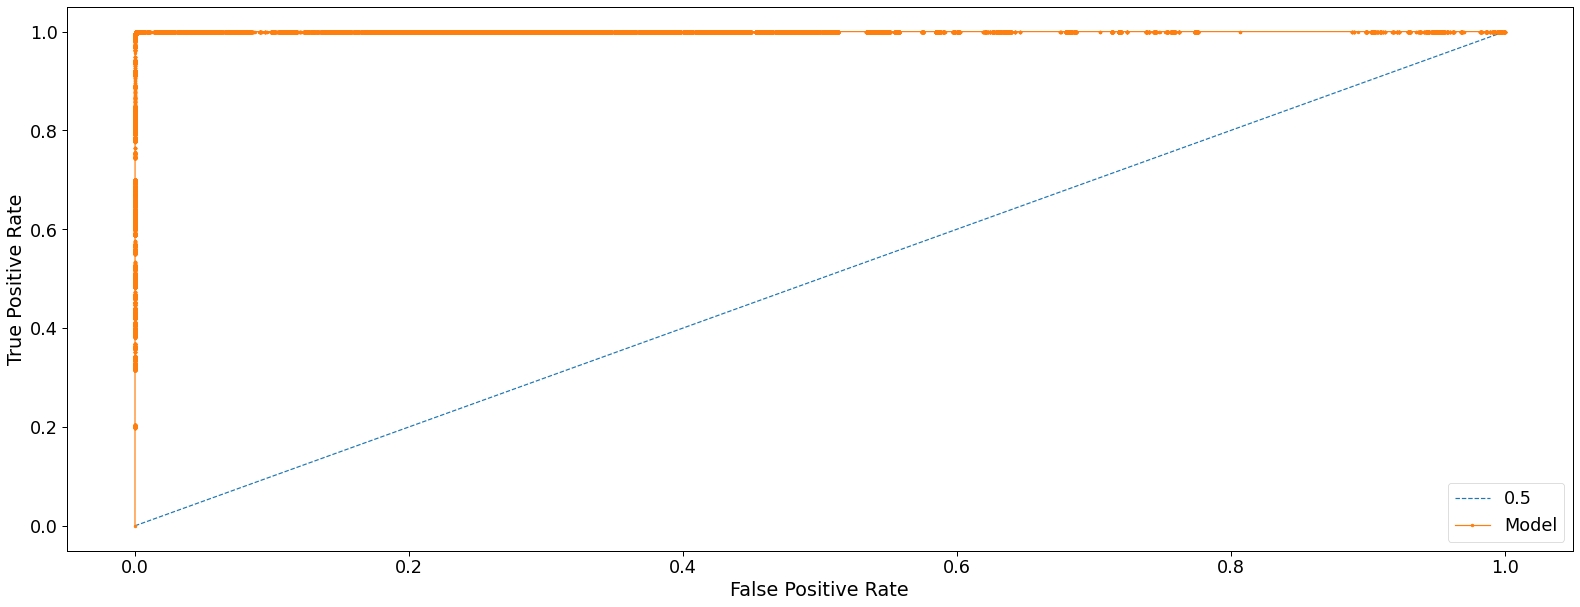

[[1276858    1397]
 [   1120 1277135]]


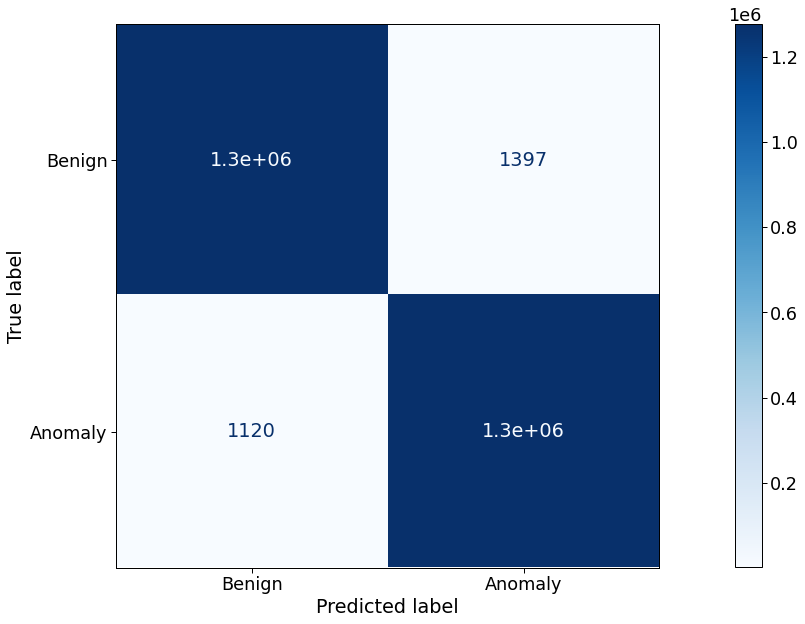

accuracy:  0.9990154546628021
f1:  0.9990155613275569
precision:  0.9989073406062579
recall:  0.9991238055004674
mcc:  0.9980309327591791


In [5]:
X_1 = np.load(folder+'X_test.npy')
y_1 = np.load(folder+'y_test.npy')

y_pred_o = clf.predict_proba(X_1)[:,1]
fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)

# Full Test Set

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  4.4min finished


Best Threshold=0.001472
Logistic: ROC AUC=0.807
Logistic: ROC AUC=0.500


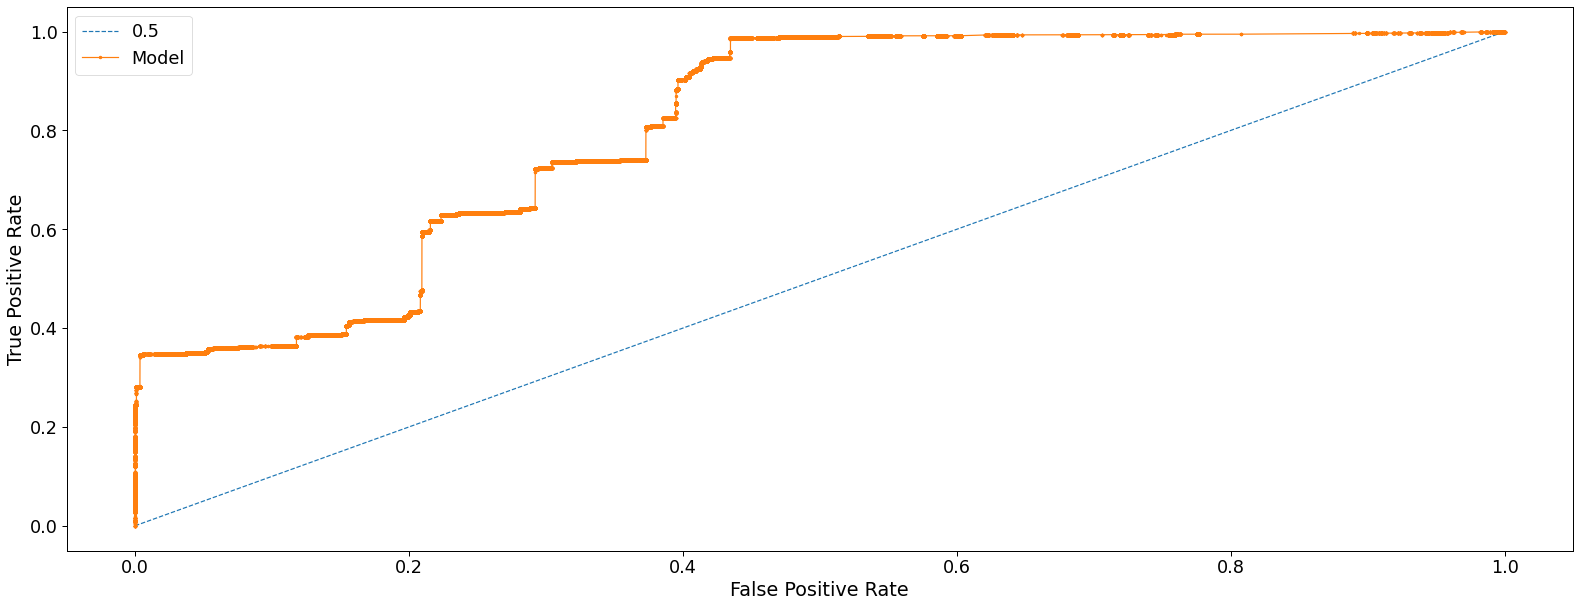

[[10359598    11148]
 [ 1600046   624458]]


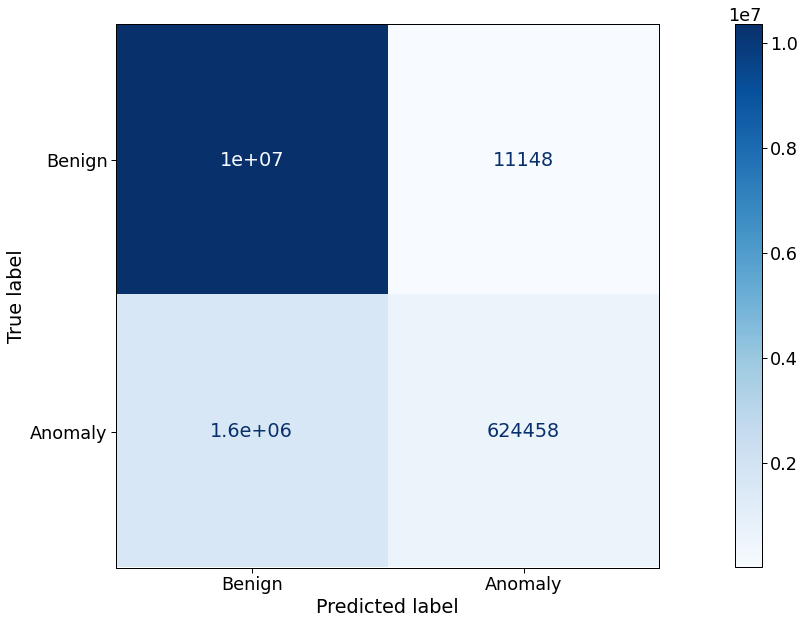

accuracy:  0.8720792362200036
f1:  0.43666712119463924
precision:  0.9824608326541915
recall:  0.2807178589024789
mcc:  0.48716074974858053
attack                    misclassification
Bot                       1                     143097
Brute Force -Web          0                          6
                          1                       2088
Brute Force -XSS          0                          5
                          1                        890
DDOS attack-HOIC          1                    1080858
DDoS attacks-LOIC-HTTP    1                     280337
DoS attacks-GoldenEye     0                      27723
DoS attacks-Hulk          0                     432487
DoS attacks-SlowHTTPTest  0                      14116
DoS attacks-Slowloris     0                       7227
FTP-BruteForce            0                      25933
Infilteration             0                      21992
                          1                      92334
SQL Injection             1                   

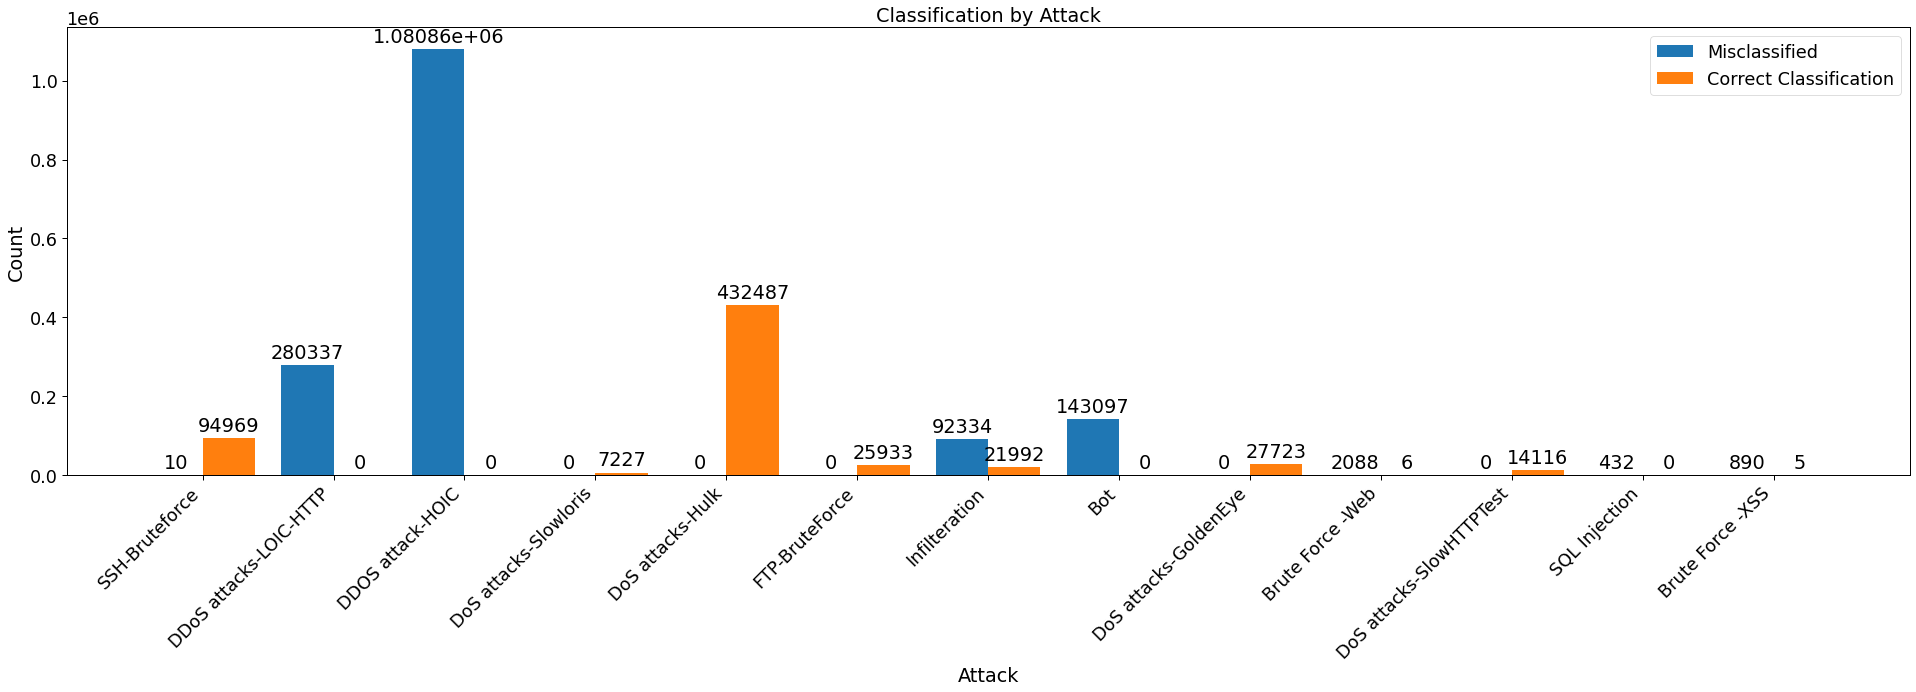

In [6]:
X_1 = np.load(folder+'X_1.npy')
y_1 = np.load(folder+'y_1.npy')
a_1 = np.load(folder+'a_1.npy',allow_pickle=True)

y_pred_o = clf.predict_proba(X_1)[:,1]
fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)
attack_report(y_pred_oround, y_1, a_1)

# Full Test Set with Threshold

Best Threshold=0.001472
[[5861674 4509072]
 [  29264 2195240]]


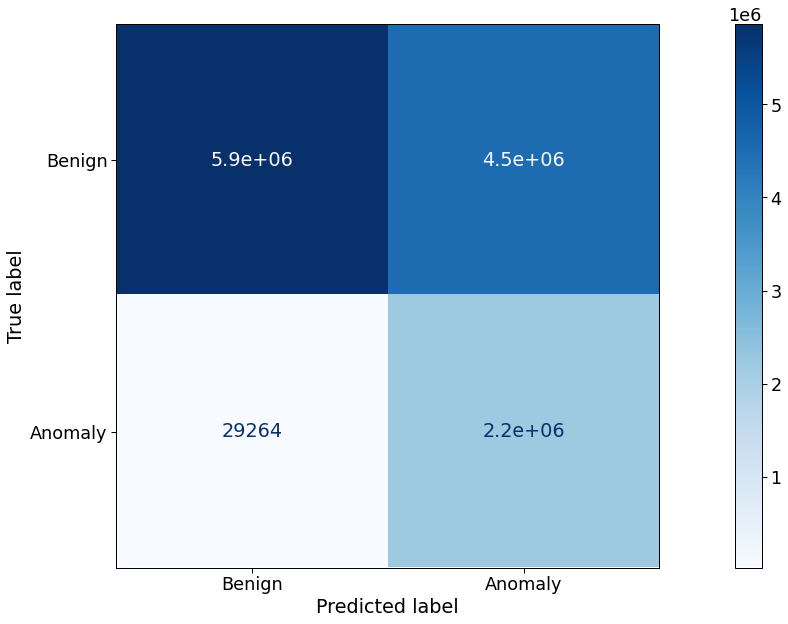

accuracy:  0.6396787677894444
f1:  0.4917202907977945
precision:  0.32743702858697504
recall:  0.9868447078539755
mcc:  0.42192596060765303
attack                    misclassification
Bot                       0                     143097
Brute Force -Web          0                       1959
                          1                        135
Brute Force -XSS          0                        893
                          1                          2
DDOS attack-HOIC          0                    1080858
DDoS attacks-LOIC-HTTP    0                     280336
                          1                          1
DoS attacks-GoldenEye     0                      27723
DoS attacks-Hulk          0                     432487
DoS attacks-SlowHTTPTest  0                      14116
DoS attacks-Slowloris     0                       7227
FTP-BruteForce            0                      25933
Infilteration             0                      85240
                          1                   

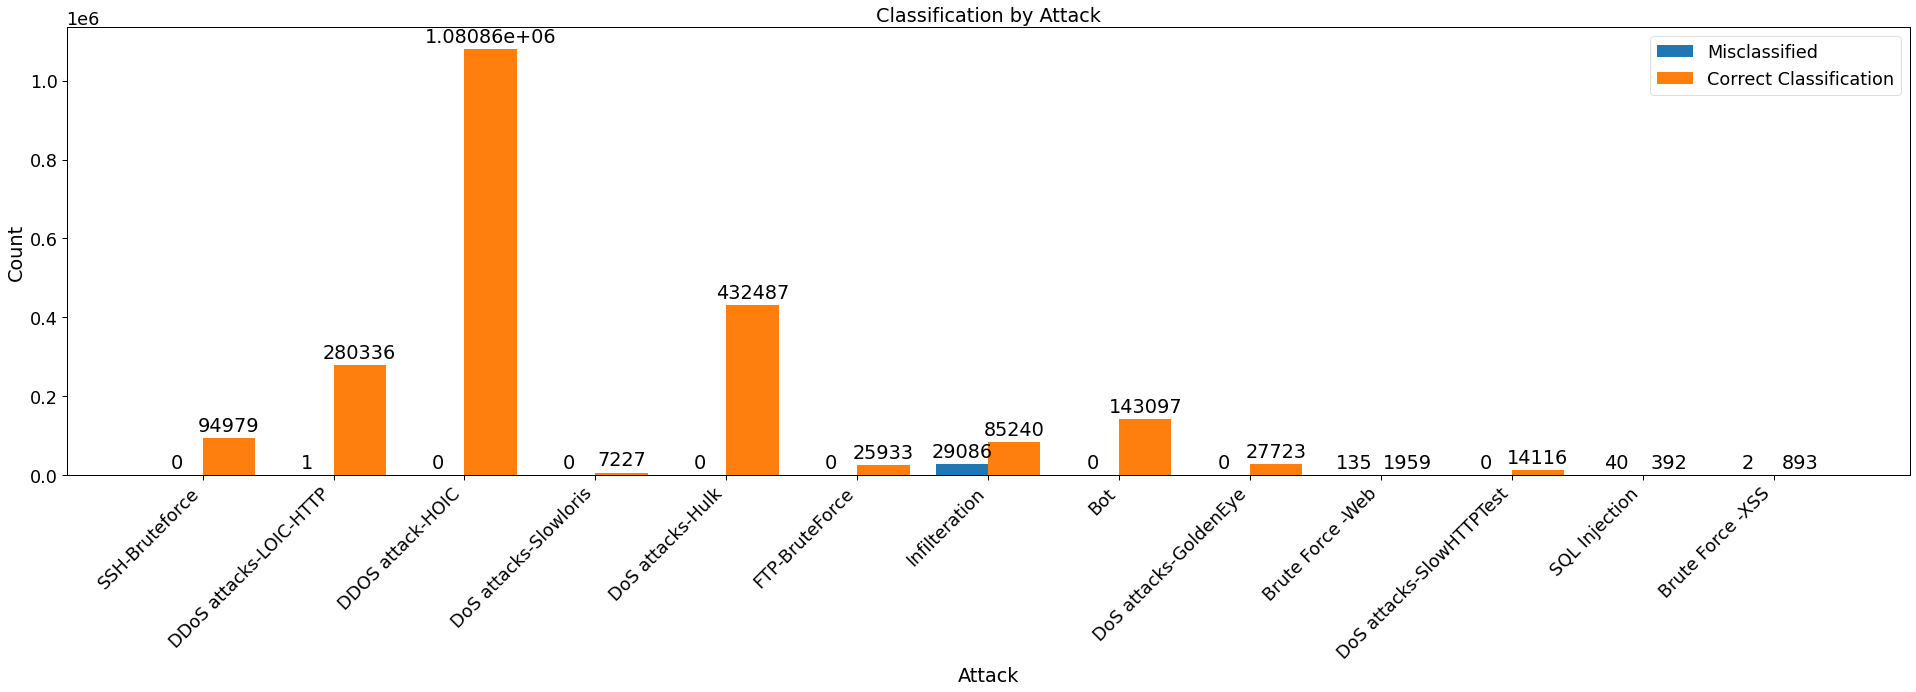

In [7]:
print('Best Threshold=%f' % (best_thresh))
y_pred2 = np.where(y_pred_o > best_thresh, 1, 0)
test_report(y_1 ,y_pred2)
attack_report(y_pred2, y_1, a_1)

# Test Set AR

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  4.2min finished


Best Threshold=0.345983
Logistic: ROC AUC=0.952
Logistic: ROC AUC=0.500


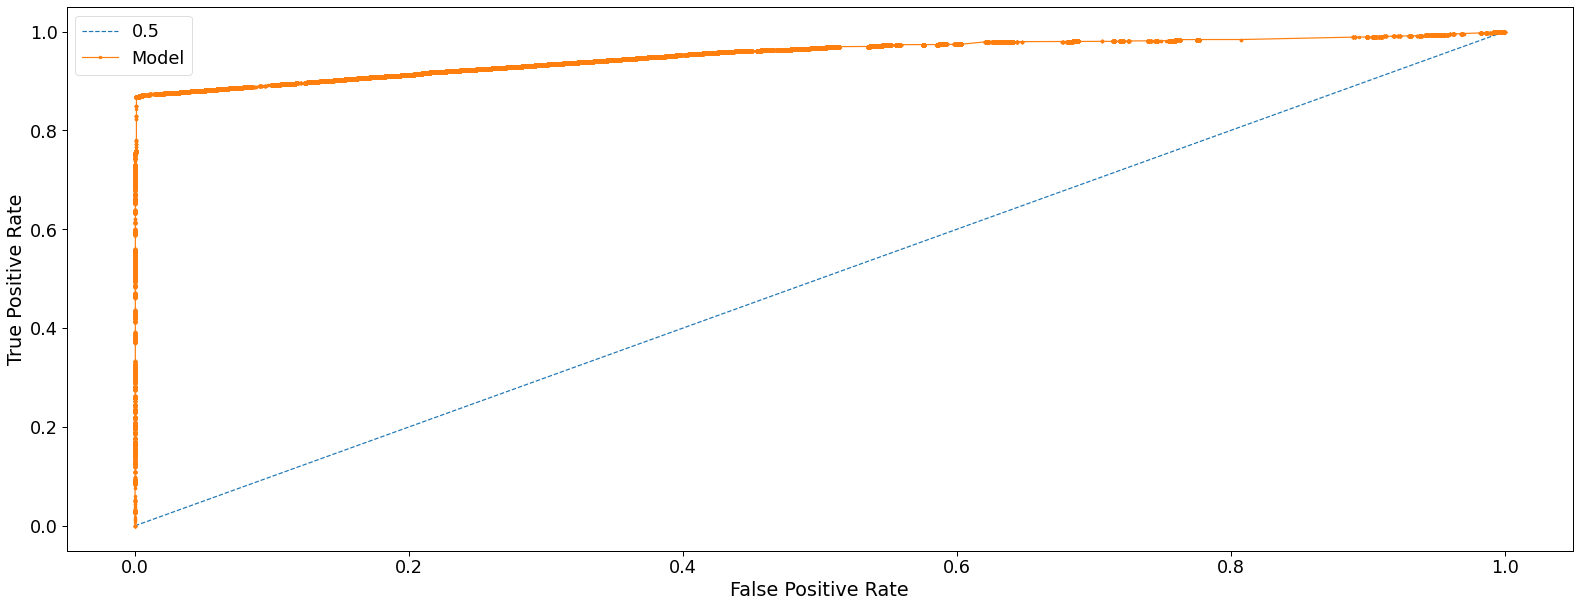

[[10359598    11148]
 [   95754   624458]]


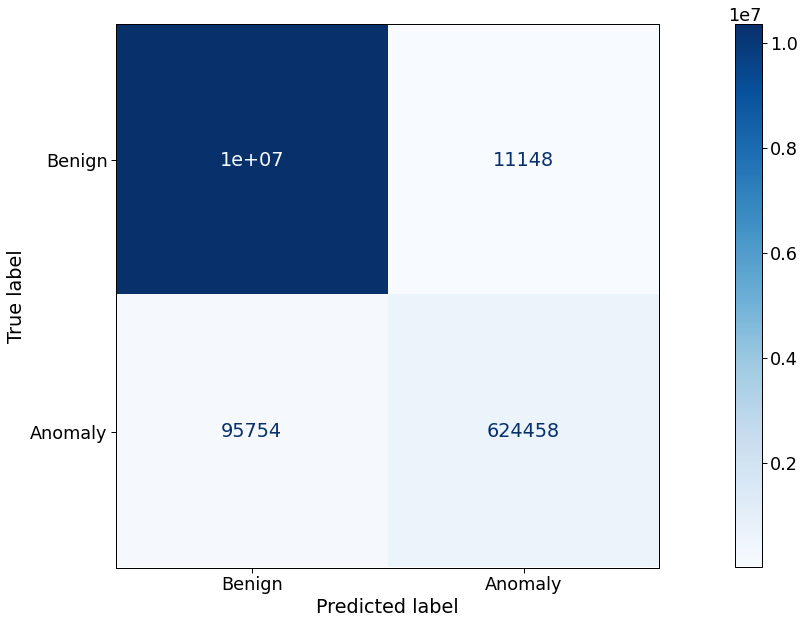

accuracy:  0.9903613375868884
f1:  0.9211531341227215
precision:  0.9824608326541915
recall:  0.8670474804640855
mcc:  0.9180703666628671
attack                    misclassification
Brute Force -Web          0                         6
                          1                      2088
Brute Force -XSS          0                         5
                          1                       890
DoS attacks-GoldenEye     0                     27723
DoS attacks-Hulk          0                    432487
DoS attacks-SlowHTTPTest  0                     14116
DoS attacks-Slowloris     0                      7227
FTP-BruteForce            0                     25933
Infilteration             0                     21992
                          1                     92334
SQL Injection             1                       432
SSH-Bruteforce            0                     94969
                          1                        10
dtype: int64
[94969, 10]
[7227]
[432487]
[25933]
[21992, 92334

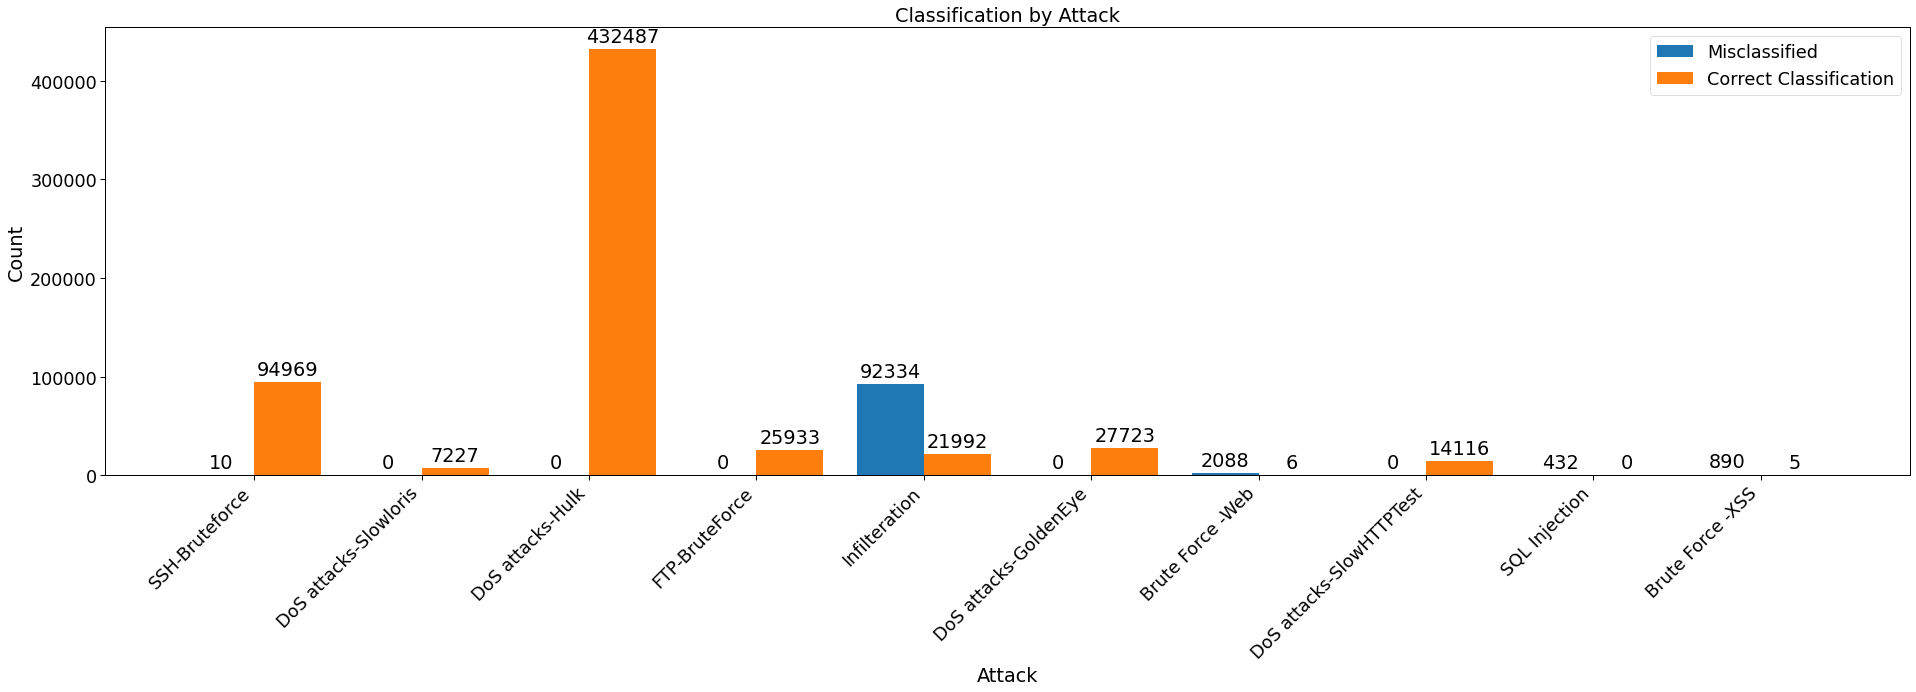

In [8]:
X_1 = np.load(folder+'X_1_ar.npy')
y_1 = np.load(folder+'y_1_ar.npy')
a_1 = np.load(folder+'a_1_ar.npy',allow_pickle=True)

y_pred_o = clf.predict_proba(X_1)[:,1]

fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)
attack_report(y_pred_oround, y_1, a_1)